In [73]:
%load_ext autoreload
%autoreload 2

from Shared.shared import *
from Shared.specific_CNB_decay import *

sim_name = f"no_gravity"
#! marias files are inside the Data/decay folder
decay_dir = f"Data/decay"
sim_folder = f"{decay_dir}/sim_output/{sim_name}"
fig_folder = f"{decay_dir}/figures_local/{sim_name}"
nu_m_range = jnp.load(f"{sim_folder}/neutrino_massrange_eV.npy")
nu_m_picks = jnp.array([0.01, 0.05, 0.1, 0.2, 0.3])*Params.eV
simdata = SimData(sim_folder)

save_dir = f"sim_output/no_gravity_decay_test"

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Pre-sim arrays

In [ ]:
Gamma_str ='2T'

angle_momentum_decay = jnp.load(
    f'{sim_folder}/neutrino_angle_momentum_decay.npy') 
decayed_neutrinos_theta = jnp.load(
    f'{sim_folder}/decayed_neutrinos_theta_{Gamma_str}.npy')
decayed_neutrinos_phi = jnp.load(
    f'{sim_folder}/decayed_neutrinos_phi_{Gamma_str}.npy')
decayed_neutrinos_z = jnp.load(
    f'{decay_dir}/decays_gamma/decayed_neutrinos_z_{Gamma_str}.npy')
decayed_neutrinos_index_z = jnp.load(
    f'{decay_dir}/decays_gamma/decayed_neutrinos_index_z_{Gamma_str}.npy', allow_pickle=True)
z_array = jnp.load(
    f'{sim_folder}/z_int_steps.npy')
neutrino_momenta = jnp.load(
    f'{sim_folder}/neutrino_momenta.npy')

common_args = (
    angle_momentum_decay, decayed_neutrinos_z, z_array, 
    neutrino_momenta,decayed_neutrinos_phi, decayed_neutrinos_theta)

ic(angle_momentum_decay.shape)
ic(decayed_neutrinos_theta.shape)
ic(decayed_neutrinos_phi.shape)
ic(decayed_neutrinos_z.shape)
ic(decayed_neutrinos_index_z.shape)
ic(z_array.shape)
ic(neutrino_momenta.shape)
print("END")

def find_nearest(array, value):
    idx = jnp.argmin(jnp.abs(array - value))
    return idx, array[idx]

## Parent number density functions

(1000, 100)
For Gamma=0.1 x T_Universe, parent nr. density:
z_dec: 56.61 (56.61)
z_0: 2.45e-03 (2.45e-03)

(1000, 100)
For Gamma=0.5 x T_Universe, parent nr. density:
z_dec: 56.61 (56.61)
z_0: 7.59e+00 (7.59e+00)

(1000, 100)
For Gamma=1.0 x T_Universe, parent nr. density:
z_dec: 56.61 (56.61)
z_0: 2.07e+01 (2.07e+01)

(1000, 100)
For Gamma=2.0 x T_Universe, parent nr. density:
z_dec: 56.61 (56.61)
z_0: 3.43e+01 (3.43e+01)



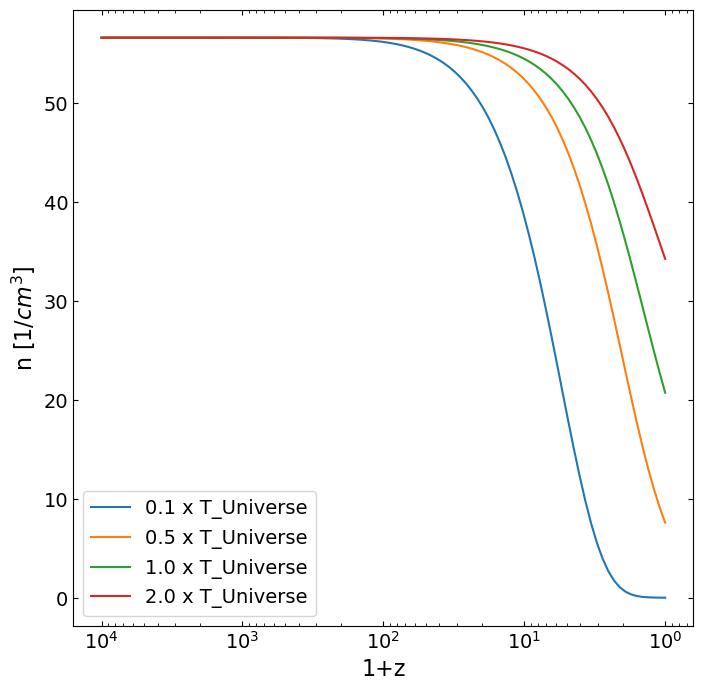

In [63]:
age_multipliers = [
    0.1, 
    0.5, 
    1., 
    2.
]

p_range = jnp.geomspace(0.01, 400, 1000)*Params.T_CNB 
z_0, z_dec = 0., 10_000.
z_range = Utils.make_logz_arr(z_0, z_dec, 100)

# note: We must have realistic neutrino masses
m_light, m_mid, m_heavy = Physics.neutrino_masses(
    m_lightest=0.05*Params.eV, ordering="NO", args=Params())

fig = plt.figure()
fig.tight_layout()
ax = fig.add_subplot(111)

for age_mult in age_multipliers:

    Gamma_val = 1/(age_mult*Params.t0)  # t0 = age of Universe

    ### New functions ###
    redshifted_p = p_range[:, None]*(1+z_range)

    n3_raw, *_ = Decay.n3_p_range(
        p=redshifted_p, z=z_range, 
        Gamma=Gamma_val, m_h=m_heavy, args=Params())
    print(n3_raw.shape)
    n3_redshifts = trap(n3_raw*redshifted_p, x=jnp.log(redshifted_p), axis=0)

    # Print & plot results.
    cm3_unit = 1/Params.cm**3
    print(f"For Gamma={age_mult} x T_Universe, parent nr. density:")
    print(f"z_dec: {jnp.max(n3_redshifts)/cm3_unit:.2f} ({n3_redshifts[-1]/cm3_unit:.2f})")
    print(f"z_0: {jnp.min(n3_redshifts)/cm3_unit:.2e} ({n3_redshifts[0]/cm3_unit:.2e})\n")
    
    ax.semilogx(
        1+z_range, n3_redshifts/cm3_unit,
        label=f"{age_mult} x T_Universe")
    ax.set_xlabel('1+z')
    ax.set_ylabel(r'n [$1/cm^3$]')

ax.invert_xaxis()
plt.legend()
plt.show()

## Inverse sampling

(768000,)
0.0 5213.492820390284
759787.0
(768000,)
0.0 3273.8369245450594
457281.0
(768000,)
0.0 2476.28653057519
279992.0
(768000,)
0.0 1872.9707338012893
156155.0


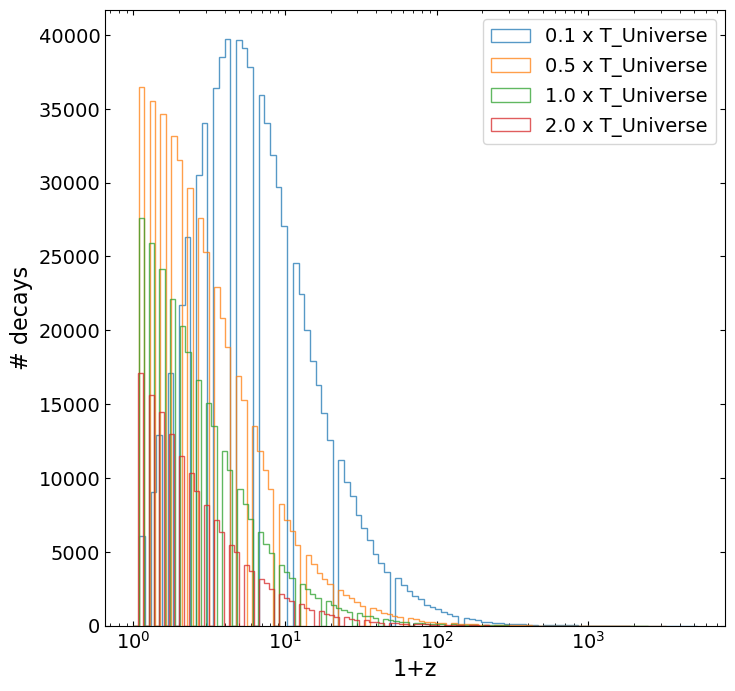

In [75]:
fig = plt.figure()
fig.tight_layout()
ax = fig.add_subplot(111)


histogram_data_l = []
for age_mult in age_multipliers:

    Gamma_val = 1/(age_mult*Params.t0)  # t0 = age of Universe

    occurences_redshifts = Decay.montecarlo(
        z_range, p_range, m_heavy, simdata.nus_in_sim, Gamma_val, Params())
    print(occurences_redshifts.shape)
    print(occurences_redshifts.min(), occurences_redshifts.max())

    # Generating logarithmically spaced bins
    log_bins = np.logspace(
        np.log10(np.min(1+occurences_redshifts)), 
        np.log10(np.max(1+occurences_redshifts)), 100)

    histogram_data, bins, _ = ax.hist(
        occurences_redshifts, bins=log_bins, histtype="step",
        alpha=0.75, label=f"{age_mult} x T_Universe")
    # has shape bins-1

    print(histogram_data.sum())
    histogram_data_l.append(histogram_data)

jnp.save(f"{save_dir}/histrogram_data.npy", jnp.array(histogram_data_l))

ax.set_xlabel("1+z")
ax.set_xscale("log")
ax.set_ylabel("# decays")
# ax.invert_xaxis()
plt.legend()
plt.show()

#? why the zeros in some bins hmm...not too important for now

## Generating pre-sim arrays

### Indices, redshifts and angles

In [89]:

def decay_neutrinos(histogram_data, gamma_str, neutrinos, save_dir):

    # Create an array representing individual neutrinos (all ones)
    neutrinos_array = np.ones(neutrinos)

    # Lists to store decayed information for each redshift step
    decayed_redshift = []
    neutrinos_decayed_index = []
    neutrinos_decayed_theta = []
    neutrinos_decayed_phi = []

    # Track remaining neutrino indices
    remaining_indices = np.arange(neutrinos)
    
    # Iterate over redshift steps
    for num_decayed in histogram_data:
        
        # Randomly select neutrinos to decay without replacement
        selected_indices = np.random.choice(remaining_indices, size=num_decayed, replace=False)
        
        # Remove selected indices from remaining indices
        remaining_indices = np.setdiff1d(remaining_indices, selected_indices)
        
        # Generate random angles
        thetas = np.random.randint(0, 180, size=num_decayed)
        phis = np.random.randint(0, 360, size=num_decayed)
        
        # Append and store values
        neutrinos_decayed_index.append(selected_indices)
        neutrinos_decayed_theta.extend(thetas)
        neutrinos_decayed_phi.extend(phis)
        
        # Update neutrinos_array to reflect decayed neutrinos
        neutrinos_array[selected_indices] = 0
        decayed_redshift.append(np.copy(neutrinos_array))

    # One check if part of routine worked
    print(len(remaining_indices))
    print(neutrinos - histogram_data.sum())
    
    # Save the results
    neutrinos_decayed_index_array = np.array(neutrinos_decayed_index, dtype=object)
    np.save(f'{save_dir}/decayed_neutrinos_index_z_{gamma_str}.npy', neutrinos_decayed_index_array)
    np.save(f'{save_dir}/decayed_neutrinos_z_{gamma_str}.npy', decayed_redshift)
    np.save(f'{save_dir}/decayed_neutrinos_theta_{gamma_str}.npy', neutrinos_decayed_theta)
    np.save(f'{save_dir}/decayed_neutrinos_phi_{gamma_str}.npy', neutrinos_decayed_phi)

    print(np.array(decayed_redshift).shape)


gamma_strings = [
    "0.1T",
    "0.5T",
    "1T",
    "2T",
]

hist_data_arr = np.load(f"{save_dir}/histrogram_data.npy").astype(int)
for hist_data, g_str in zip(hist_data_arr, gamma_strings):

    decay_neutrinos(
        histogram_data=hist_data, gamma_str=g_str, 
        neutrinos=simdata.nus_in_sim, save_dir=save_dir)


8213
8213
(99, 768000)
310719
310719
(99, 768000)
488008
488008
(99, 768000)
611845
611845
(99, 768000)


### Decay momenta (work in progress...)

In [104]:
momentum_daughter = Decay.daughter_momentum(
    p_h_array=p_range[::100], m_l=m_light, m_phi=1e-6, m_h=m_heavy, angle_reso=20)
print(momentum_daughter)

[[ 0.01775309  0.01775547  0.01776235  0.01778221  0.0178396   0.01800549
   0.01848563  0.0198806   0.02397723  0.03635072]
 [ 0.01775301  0.01775525  0.01776171  0.01778038  0.01783428  0.01798997
   0.0184395   0.0197363   0.02346226  0.03386289]
 [ 0.01775279  0.01775462  0.01775989  0.01777509  0.01781897  0.01794536
   0.01830737  0.01932686  0.02203509  0.02720974]
 [ 0.01775246  0.01775365  0.01775709  0.017767    0.01779555  0.01787725
   0.01810693  0.0187168   0.02000529  0.01824978]
 [ 0.01775205  0.01775246  0.01775365  0.01775708  0.01776686  0.01779409
   0.01786434  0.0179965   0.01776583  0.00929383]
 [ 0.01775161  0.0177512   0.01775     0.01774653  0.01773638  0.01770607
   0.01761013  0.01726322  0.01567141 -0.00929383]
 [ 0.0177512   0.01775001  0.01774657  0.01773662  0.0177078   0.01762379
   0.01737492  0.01660465  0.01395725 -0.01824978]
 [ 0.01775086  0.01774904  0.01774377  0.01772855  0.01768453  0.01755704
   0.0171858   0.01608912  0.01272782 -0.02720974]


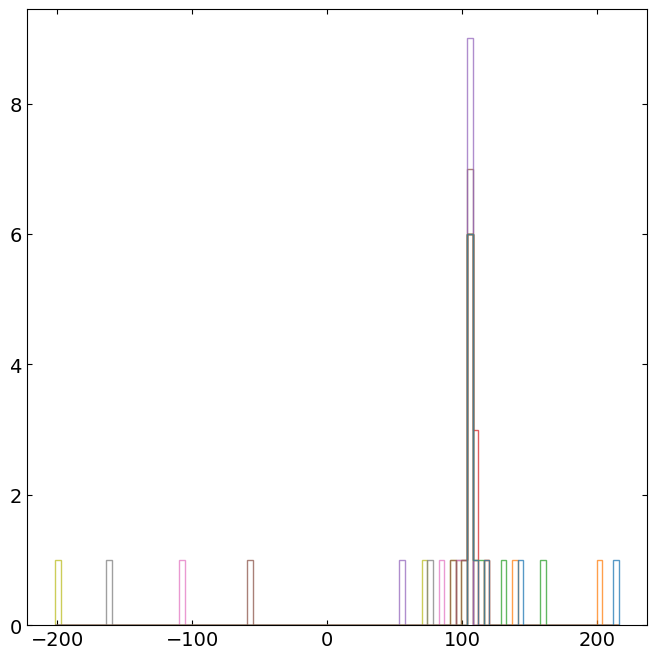

In [107]:
fig = plt.figure()
fig.tight_layout()
ax = fig.add_subplot(111)

# Generating logarithmically spaced bins
# momentum_daughter /= Params.T_CNB
# log_bins = np.logspace(
#     np.log10(np.min(1+momentum_daughter)), 
#     np.log10(np.max(1+momentum_daughter)), 100)

histogram_data, bins, _ = ax.hist(
    momentum_daughter, bins=100, histtype="step",
    alpha=0.75, label=f"{age_mult} x T_Universe")
# has shape bins-1

## EOMs_no_gravity routine (work in progress...)

In [ ]:
angle_momentum_decay, decayed_neutrinos_z, z_array, neutrino_momenta,decayed_neutrinos_phi, decayed_neutrinos_theta = common_args

print(jnp.count_nonzero(decayed_neutrinos_z[-1]), simdata.nus_in_sim)

z = 4

z_nearest = find_nearest(z_array, z)

# Find correct index for z_array, that corresponds to current z
z_index, z_nearest = find_nearest(z_array, z)

Nr_index = 0
now_nu_number = jnp.int16(decayed_neutrinos_z[z_index, Nr_index])
pre_nu_number = jnp.int16(decayed_neutrinos_z[z_index-1, Nr_index])

print(now_nu_number, pre_nu_number)

# p_i = find_nearest(neutrino_momenta, 0.06 * jnp.linalg.norm(u_i_p, axis=-1))
# p_index = jnp.argmax(jnp.equal(neutrino_momenta, p_i))